# 🛫 Projeto – Modelagem Estatística (2º Bimestre)
## Predição e Classificação de Atrasos em Voos (US Flights)

**Curso:** Ciência da Computação  
**Disciplina:** Modelagem Estatística  
**Alunos:** *Tiago Ferreira Da Silva e João Dário Pamplona Arruda*  
**Professor:** Pedro Henrique Sales Girotto  

---

# 🎯 1. Introdução

O objetivo deste projeto é analisar um conjunto de dados de voos dos Estados Unidos e desenvolver modelos de **regressão** e **classificação** capazes de:

1. **Predizer o atraso de chegada (em minutos)** de um voo (problema de regressão);
2. **Classificar se um voo atrasa ou não além de 15 minutos** (problema de classificação binária).

Do ponto de vista de negócio, esse tipo de modelo pode apoiar:

- Planejamento de malha aérea;
- Comunicação proativa com passageiros;
- Mitigação de risco operacional (janelas de conexão, alocação de portões, etc.).

### Hipóteses de negócio

1. Voos com **partida no final do dia** têm maior probabilidade de atraso.
2. Companhias aéreas possuem **padrões de atraso diferentes** entre si.
3. Voos **mais longos (DISTANCE)** tendem a ter maior atraso médio.

### Variável-alvo

- **Regressão:** `ARRIVAL_DELAY` (atraso em minutos na chegada);
- **Classificação:** `IS_DELAYED` (0 = não atrasado / 1 = atrasado mais de 15 minutos).

---

## 📂 2. Fonte e Licença do Dataset

Os dados utilizados neste projeto foram obtidos através da plataforma **Kaggle** (https://www.kaggle.com/datasets/usdot/flight-delays), que disponibiliza uma versão organizada do dataset oficial do **Bureau of Transportation Statistics (BTS)**. O **BTS** é a fonte primária dos dados originais, disponibilizados sob domínio público pelo **U.S. Department of Transportation**. O **Kaggle** atua apenas como repositório secundário para facilitar acesso e manipulação.

- **Fonte oficial:** https://www.transtats.bts.gov  
- **Link do Kaggle:** https://www.kaggle.com/datasets/usdot/flight-delays
- **Base típica utilizada:** On-Time Performance Dataset  
- **Responsável:** U.S. Department of Transportation  
- **Licença:** Dados públicos disponibilizados pelo governo federal dos EUA, regidos por *Public Domain* conforme 17 U.S.C. § 105.

### Estrutura resumida do dataset

Principais variáveis empregadas no projeto:

- `ARRIVAL_DELAY`: atraso na chegada (minutos) → variável-alvo para regressão  
- `IS_DELAYED`: atraso binário (> 15 min) → variável-alvo para classificação  
- `DISTANCE`: distância do voo (milhas)  
- `AIR_TIME`: tempo de voo (minutos)  
- `SCHEDULED_DEPARTURE`: horário programado de partida  
- `AIRLINE`: companhia aérea  

In [1]:
# ======== IMPORTS ========

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import f_oneway, ttest_ind, chi2_contingency, shapiro
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve,
    ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
# ======== CARREGANDO O DATASET ========

# O arquivo flights.csv deve estar na mesma pasta do notebook
flights = pd.read_csv("flights.csv")

print("Dimensões do dataset:", flights.shape)
display(flights.head())

print("\nInformação geral:")
display(flights.info())

print("\nEstatísticas descritivas das colunas numéricas:")
display(flights.describe())

C:\Users\tiago\AppData\Local\Temp\ipykernel_16112\595567805.py:4: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv("flights.csv")


Dimensões do dataset: (5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN



Informação geral:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED     

None


Estatísticas descritivas das colunas numéricas:


,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,5819079.0,5.819079e+06,5.819079e+06,5.819079e+06,5.819079e+06,5.819079e+06,5.732926e+06,5.732926e+06,5.730032e+06,5.730032e+06,...,5.819079e+06,5.726566e+06,5.714008e+06,5.819079e+06,5.819079e+06,1.063439e+06,1.063439e+06,1.063439e+06,1.063439e+06,1.063439e+06
mean,2015.0,6.524085e+00,1.570459e+01,3.926941e+00,2.173093e+03,1.329602e+03,1.335204e+03,9.370158e+00,1.607166e+01,1.357171e+03,...,1.493808e+03,1.476491e+03,4.407057e+00,2.609863e-03,1.544643e-02,1.348057e+01,7.615387e-02,1.896955e+01,2.347284e+01,2.915290e+00
std,0.0,3.405137e+00,8.783425e+00,1.988845e+00,1.757064e+03,4.837518e+02,4.964233e+02,3.708094e+01,8.895574e+00,4.980094e+02,...,5.071647e+02,5.263197e+02,3.927130e+01,5.102012e-02,1.233201e-01,2.800368e+01,2.143460e+00,4.816164e+01,4.319702e+01,2.043334e+01
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,-8.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,7.300000e+02,9.170000e+02,9.210000e+02,-5.000000e+00,1.100000e+01,9.350000e+02,...,1.110000e+03,1.059000e+03,-1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.690000e+03,1.325000e+03,1.330000e+03,-2.000000e+00,1.400000e+01,1.343000e+03,...,1.520000e+03,1.512000e+03,-5.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,3.230000e+03,1.730000e+03,1.740000e+03,7.000000e+00,1.900000e+01,1.754000e+03,...,1.918000e+03,1.917000e+03,8.000000e+00,0.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,1.900000e+01,2.900000e+01,0.000000e+00
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,9.855000e+03,2.359000e+03,2.400000e+03,1.988000e+03,2.250000e+02,2.400000e+03,...,2.400000e+03,2.400000e+03,1.971000e+03,1.000000e+00,1.000000e+00,1.134000e+03,5.730000e+02,1.971000e+03,1.331000e+03,1.211000e+03


In [3]:
# ======== 3. PREPARAÇÃO DE DADOS ========

df = flights.copy()

# Mantemos apenas linhas com atraso de chegada não nulo
df = df.dropna(subset=["ARRIVAL_DELAY"])

# Criamos variável binária de atraso significativo (> 15 minutos)
df["IS_DELAYED"] = (df["ARRIVAL_DELAY"] > 15).astype(int)

# Extraímos hora da partida a partir de SCHEDULED_DEPARTURE (ex.: 1345 -> 13h)
df["DEP_HOUR"] = df["SCHEDULED_DEPARTURE"].astype(str).str.zfill(4).str[:2].astype(int)

# Tratamento de valores ausentes numéricos com mediana
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

print("Colunas após preparação:")
print(df.columns.tolist())
display(df.head())

Colunas após preparação:
['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'IS_DELAYED', 'DEP_HOUR']


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IS_DELAYED,DEP_HOUR
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,0,0,NaN,2.0,0.0,2.0,3.0,0.0,0,0


In [4]:
# ======== 4. DETECÇÃO E TRATAMENTO DE OUTLIERS (IQR) ========

def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    
    df_clean = df[(df[col] >= lim_inf) & (df[col] <= lim_sup)]
    
    return df_clean, lim_inf, lim_sup

df_clean, low, high = remove_outliers_iqr(df, "ARRIVAL_DELAY")

print(f"Faixa aceitável de outliers: {low:.2f} a {high:.2f}")
print(f"Quantidade antes: {len(df)}, depois: {len(df_clean)}")

# Atualiza o dataframe usado no restante da análise, se desejado
df = df_clean.copy()

Faixa aceitável de outliers: -44.50 a 39.50
Quantidade antes: 5714008, depois: 5202006


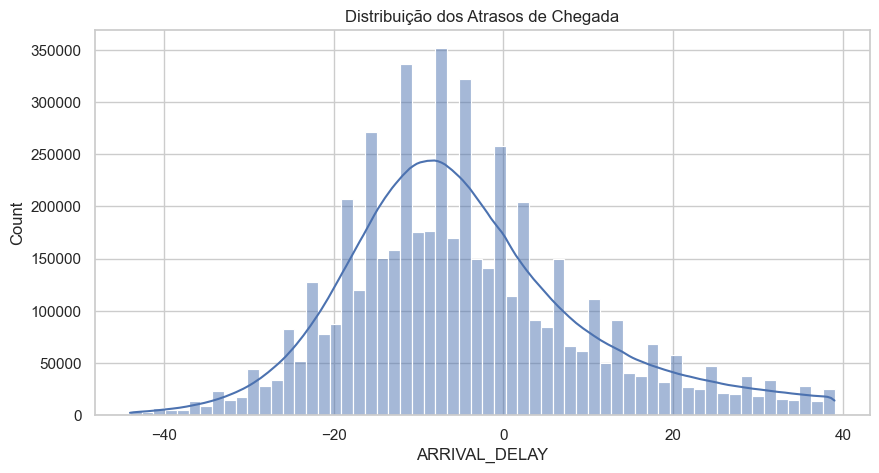

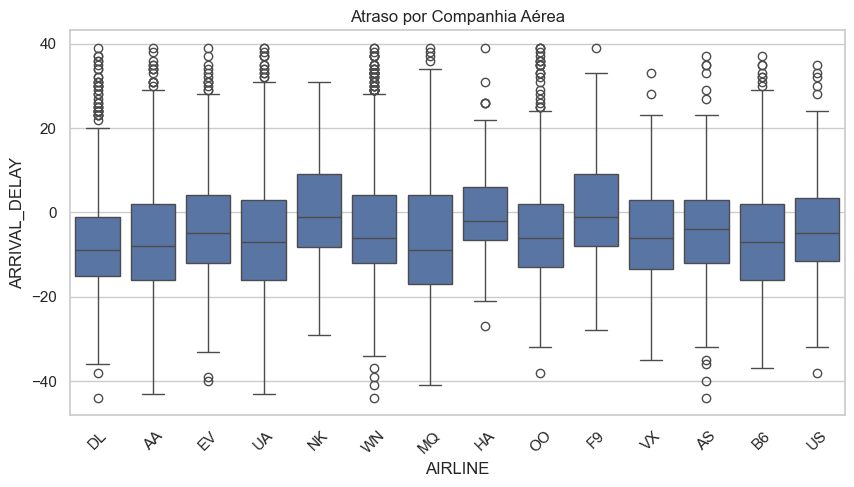

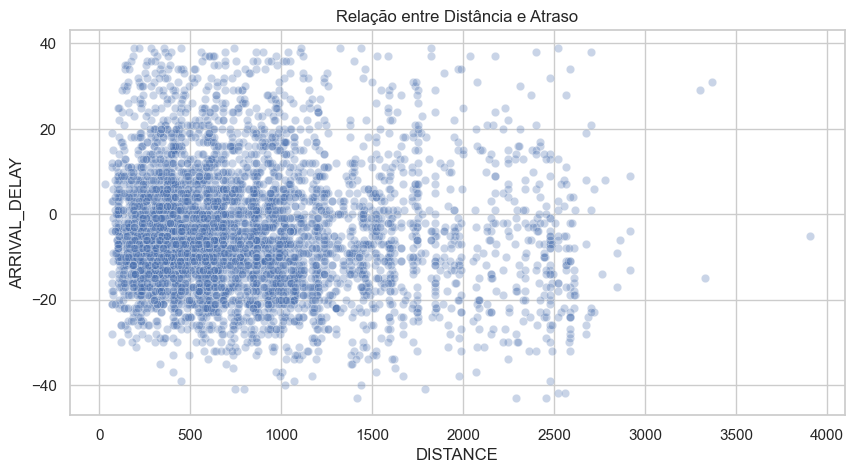

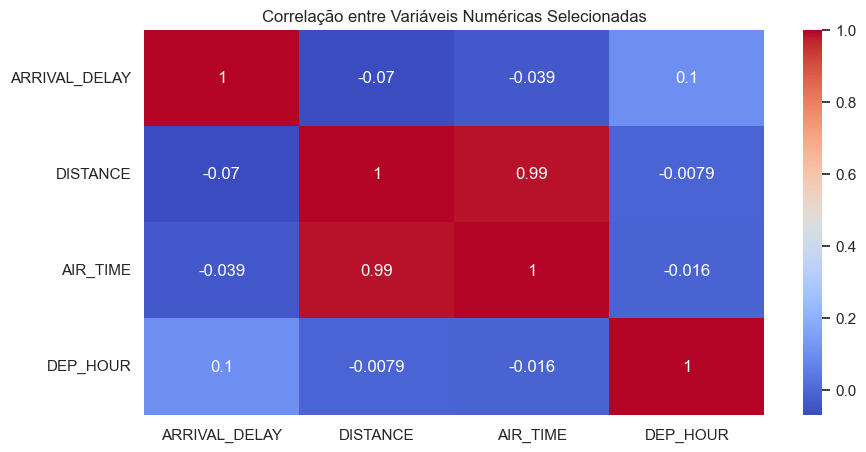

In [5]:
# ======== 5. EDA (Análise Exploratória) ========

# Distribuição do atraso
sns.histplot(df["ARRIVAL_DELAY"], bins=60, kde=True)
plt.title("Distribuição dos Atrasos de Chegada")
plt.show()

# Atraso por companhia aérea (amostra para visualização)
sns.boxplot(data=df.sample(min(5000, len(df))), x="AIRLINE", y="ARRIVAL_DELAY")
plt.xticks(rotation=45)
plt.title("Atraso por Companhia Aérea")
plt.show()

# Distância vs atraso
sns.scatterplot(data=df.sample(min(5000, len(df))), x="DISTANCE", y="ARRIVAL_DELAY", alpha=0.3)
plt.title("Relação entre Distância e Atraso")
plt.show()

# Correlação entre variáveis selecionadas
corr_cols = ["ARRIVAL_DELAY", "DISTANCE", "AIR_TIME", "DEP_HOUR"]
sns.heatmap(df[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlação entre Variáveis Numéricas Selecionadas")
plt.show()

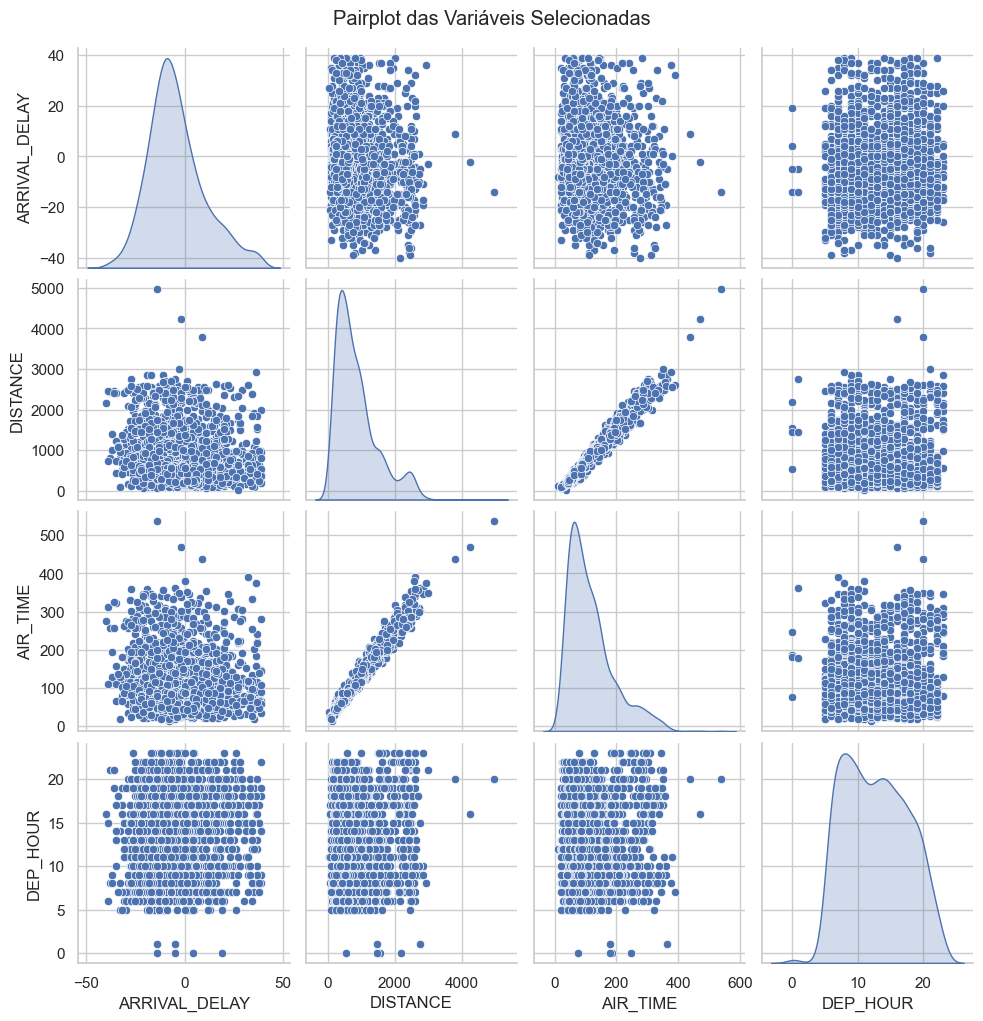

In [6]:
# ======== 5.1 Pairplot (amostra para evitar lentidão) ========

import seaborn as sns

sample_pp = df.sample(min(2000, len(df)), random_state=42)

sns.pairplot(
    sample_pp[["ARRIVAL_DELAY", "DISTANCE", "AIR_TIME", "DEP_HOUR"]],
    diag_kind="kde"
)
plt.suptitle("Pairplot das Variáveis Selecionadas", y=1.02)
plt.show()

In [7]:
# ======== 5.2 TESTES ESTATÍSTICOS ========

# ANOVA: atraso entre as 5 companhias com mais voos
top_airlines = df["AIRLINE"].value_counts().head(5).index
anova_groups = [df[df["AIRLINE"] == a]["ARRIVAL_DELAY"] for a in top_airlines]
f_stat, p_val = f_oneway(*anova_groups)
print(f"ANOVA atraso ~ companhia (top 5): F = {f_stat:.3f}, p-value = {p_val:.6f}")

# Teste t: voos dia (< 18h) vs noite (>= 18h)
day = df[df["DEP_HOUR"] < 18]["ARRIVAL_DELAY"]
night = df[df["DEP_HOUR"] >= 18]["ARRIVAL_DELAY"]
t_stat, p_val_t = ttest_ind(day, night, equal_var=False)
print(f"\nTeste t (dia vs noite): t = {t_stat:.3f}, p-value = {p_val_t:.6f}")

# Qui-Quadrado: companhias (top 5) x atraso binário
table = pd.crosstab(df["AIRLINE"].isin(top_airlines), df["IS_DELAYED"])
chi2, p_chi, dof, expected = chi2_contingency(table)
print(f"\nQui-Quadrado atraso ~ top5 airline: chi2 = {chi2:.3f}, p-value = {p_chi:.6f}")

# Normalidade (Shapiro-Wilk) em uma amostra dos atrasos
sample_delay = df["ARRIVAL_DELAY"].sample(min(1000, len(df)), random_state=42)
w_stat, p_shapiro = shapiro(sample_delay)
print(f"\nShapiro-Wilk (amostra de ARRIVAL_DELAY): W = {w_stat:.3f}, p-value = {p_shapiro:.6f}")


ANOVA atraso ~ companhia (top 5): F = 9254.654, p-value = 0.000000

Teste t (dia vs noite): t = -122.535, p-value = 0.000000

Qui-Quadrado atraso ~ top5 airline: chi2 = 1797.693, p-value = 0.000000

Shapiro-Wilk (amostra de ARRIVAL_DELAY): W = 0.971, p-value = 0.000000


In [8]:
# ======== 6. BASELINE DE REGRESSÃO (Sempre Predizer a Média) ========

baseline_value = df["ARRIVAL_DELAY"].mean()
baseline_pred = np.repeat(baseline_value, len(df))

mae_baseline = mean_absolute_error(df["ARRIVAL_DELAY"], baseline_pred)
mse_baseline = mean_squared_error(df["ARRIVAL_DELAY"], baseline_pred)
rmse_baseline = mse_baseline ** 0.5
r2_baseline = r2_score(df["ARRIVAL_DELAY"], baseline_pred)

print("Baseline (média dos atrasos):", baseline_value)
print("MAE Baseline:", mae_baseline)
print("MSE Baseline:", mse_baseline)
print("RMSE Baseline:", rmse_baseline)
print("R2 Baseline:", r2_baseline)

Baseline (média dos atrasos): -4.476263003156859
MAE Baseline: 11.121823775709924
MSE Baseline: 207.15503950891826
RMSE Baseline: 14.392881556829343
R2 Baseline: 0.0


MAE: 11.119951238249017
MSE: 205.8589256809156
RMSE: 14.347784695935314
R2: 0.004899737751300148


C:\Users\tiago\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


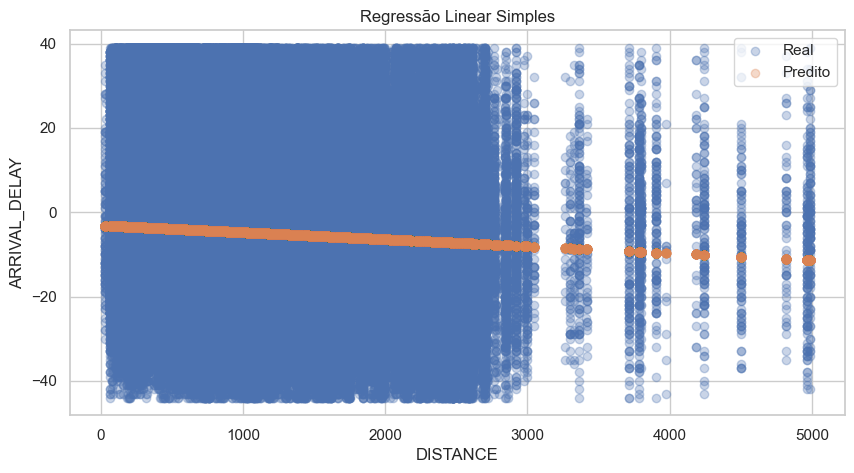

In [9]:
# ======== 7. REGRESSÃO LINEAR SIMPLES: DISTANCE → ARRIVAL_DELAY ========

X_lin = df[["DISTANCE"]]
y_reg = df["ARRIVAL_DELAY"]

X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_lin, y_reg, test_size=0.2, random_state=42
)

lin = LinearRegression()
lin.fit(X_train_lin, y_train_lin)

y_pred_lin = lin.predict(X_test_lin)

mse_lin = mean_squared_error(y_test_lin, y_pred_lin)
rmse_lin = mse_lin ** 0.5

print("MAE:", mean_absolute_error(y_test_lin, y_pred_lin))
print("MSE:", mse_lin)
print("RMSE:", rmse_lin)
print("R2:", r2_score(y_test_lin, y_pred_lin))

# Visualização
plt.scatter(X_test_lin, y_test_lin, alpha=0.3, label="Real")
plt.scatter(X_test_lin, y_pred_lin, alpha=0.3, label="Predito")
plt.xlabel("DISTANCE")
plt.ylabel("ARRIVAL_DELAY")
plt.legend()
plt.title("Regressão Linear Simples")
plt.show()

In [10]:
# ======== 8. REGRESSÃO LINEAR MÚLTIPLA (Sklearn) ========

features_reg = ["DISTANCE", "AIR_TIME", "DEP_HOUR"]
X_reg = df[features_reg]
y_reg = df["ARRIVAL_DELAY"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

lin_multi = LinearRegression()
lin_multi.fit(X_train_reg, y_train_reg)

y_pred_multi = lin_multi.predict(X_test_reg)

mse_multi = mean_squared_error(y_test_reg, y_pred_multi)
rmse_multi = mse_multi ** 0.5

print("MAE:", mean_absolute_error(y_test_reg, y_pred_multi))
print("MSE:", mse_multi)
print("RMSE:", rmse_multi)
print("R2:", r2_score(y_test_reg, y_pred_multi))

coef_table = pd.DataFrame({
    "Variável": ["Intercept"] + features_reg,
    "Coeficiente": [lin_multi.intercept_] + list(lin_multi.coef_)
})

display(coef_table)

MAE: 10.800168745120065
MSE: 196.46484034489345
RMSE: 14.016591609406811
R2: 0.050309752160643595


,Variável,Coeficiente
0,Intercept,-11.210283
1,DISTANCE,-0.028607
2,AIR_TIME,0.230848
3,DEP_HOUR,0.324657


In [11]:
# ======== 9. REGRESSÃO POLINOMIAL (Grau 2) ========

poly = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly.fit_transform(df[["DISTANCE"]])
y_poly = df["ARRIVAL_DELAY"]

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(
    X_poly, y_poly, test_size=0.2, random_state=42
)

lin_poly = LinearRegression()
lin_poly.fit(X_train_poly, y_train_poly)

y_pred_poly = lin_poly.predict(X_test_poly)

mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
rmse_poly = mse_poly ** 0.5

print("MAE:", mean_absolute_error(y_test_poly, y_pred_poly))
print("MSE:", mse_poly)
print("RMSE:", rmse_poly)
print("R2:", r2_score(y_test_poly, y_pred_poly))

poly_features = poly.get_feature_names_out(["DISTANCE"])
coef_poly = pd.DataFrame({
    "Termo": ["Intercept"] + list(poly_features),
    "Coeficiente": [lin_poly.intercept_] + list(lin_poly.coef_)
})

display(coef_poly)

MAE: 11.119053607754221
MSE: 205.8172497967389
RMSE: 14.346332276813433
R2: 0.005101194565166889


,Termo,Coeficiente
0,Intercept,-2.711861e+00
1,DISTANCE,-2.632510e-03
2,DISTANCE^2,3.905172e-07


In [12]:
# ======== 10. REGRESSÃO MÚLTIPLA COM STATSMODELS + VIF ========

X_sm = sm.add_constant(X_reg)
model_sm = sm.OLS(y_reg, X_sm).fit()

print(model_sm.summary())

# VIF
vif_data = pd.DataFrame({
    "Variável": X_sm.columns,
    "VIF": [variance_inflation_factor(X_sm.values, i) 
            for i in range(X_sm.shape[1])]
})

print("\nVIF (Variance Inflation Factor):")
display(vif_data)

                            OLS Regression Results                            
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                 9.251e+04
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        00:17:07   Log-Likelihood:            -2.1119e+07
No. Observations:             5202006   AIC:                         4.224e+07
Df Residuals:                 5202002   BIC:                         4.224e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.2176      0.022   -517.406      0.0

,Variável,VIF
0,const,12.433277
1,DISTANCE,37.232813
2,AIR_TIME,37.239525
3,DEP_HOUR,1.002330


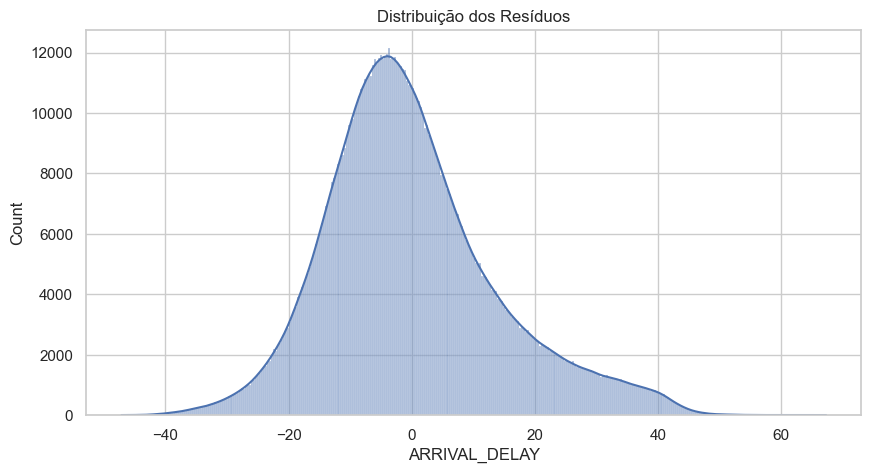

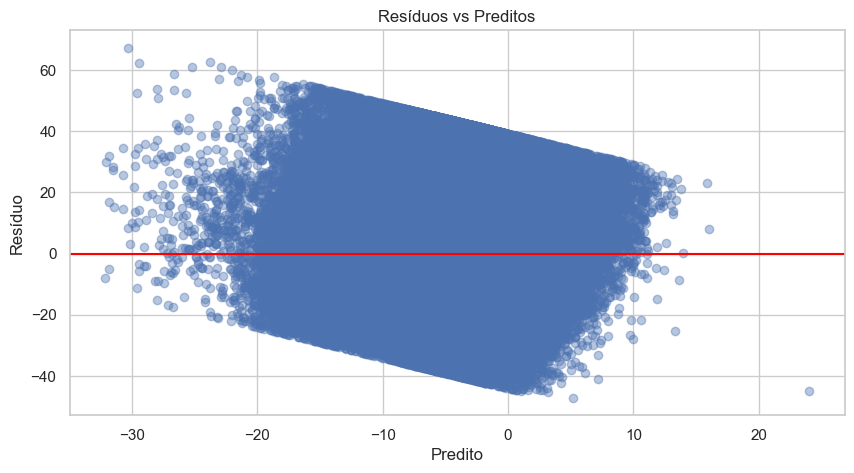

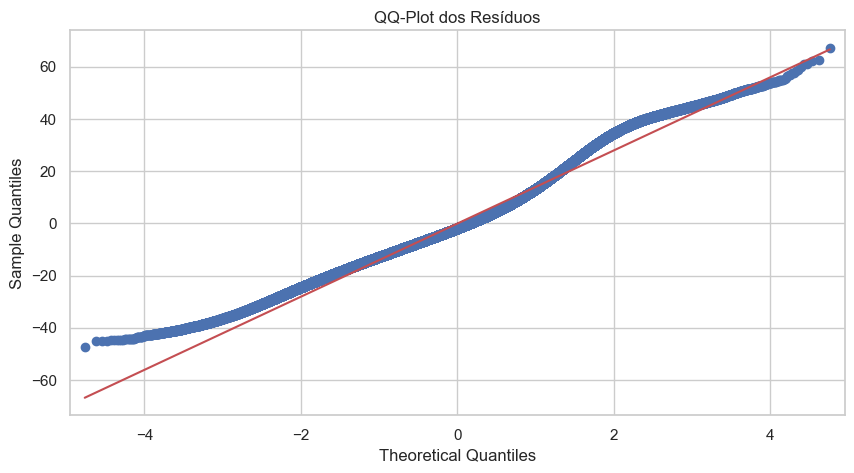

Shapiro-Wilk (resíduos): W = 0.974, p-value = 0.000000


c:\Users\tiago\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1040402.
  res = hypotest_fun_out(*samples, **kwds)


In [13]:
# ======== 11. DIAGNÓSTICO DE RESÍDUOS (Modelo Múltiplo Sklearn) ========

res = y_test_reg - y_pred_multi

sns.histplot(res, kde=True)
plt.title("Distribuição dos Resíduos")
plt.show()

plt.scatter(y_pred_multi, res, alpha=0.4)
plt.axhline(0, color='red')
plt.xlabel("Predito")
plt.ylabel("Resíduo")
plt.title("Resíduos vs Preditos")
plt.show()

# QQ-Plot
sm.qqplot(res, line='s')
plt.title("QQ-Plot dos Resíduos")
plt.show()

# Normalidade
w_stat, p_res = shapiro(res)
print(f"Shapiro-Wilk (resíduos): W = {w_stat:.3f}, p-value = {p_res:.6f}")

In [14]:
# ======== 12. TESTE DE HOMOCEDASTICIDADE — BREUSCH–PAGAN ========

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Variáveis do modelo múltiplo
X_bp = sm.add_constant(X_train_reg)  # reuse the regression features
y_bp = y_train_reg

bp_model = sm.OLS(y_bp, X_bp).fit()

bp_test = het_breuschpagan(bp_model.resid, bp_model.model.exog)

names = ["LM Statistic", "LM p-value", "F-statistic", "F p-value"]
result_bp = dict(zip(names, bp_test))

print("=== Teste de Homocedasticidade (Breusch–Pagan) ===")
for k, v in result_bp.items():
    print(f"{k}: {v:.5f}")

if result_bp["LM p-value"] > 0.05:
    print("\n→ Não rejeitamos a hipótese nula: variância constante (homocedasticidade).")
else:
    print("\n→ Rejeitamos a hipótese nula: evidência de heterocedasticidade.")

=== Teste de Homocedasticidade (Breusch–Pagan) ===
LM Statistic: 74532.39152
LM p-value: 0.00000
F-statistic: 25297.16712
F p-value: 0.00000

→ Rejeitamos a hipótese nula: evidência de heterocedasticidade.


In [15]:
# ======== 13. BASELINE DE CLASSIFICAÇÃO (Classe Majoritária) ========

y_cls = df["IS_DELAYED"]
X_cls = df[["DISTANCE", "AIR_TIME", "DEP_HOUR"]]

baseline_class = np.repeat(y_cls.mode()[0], len(y_cls))
baseline_acc = accuracy_score(y_cls, baseline_class)

print("Classe majoritária (baseline):", y_cls.mode()[0])
print("Accuracy Baseline:", baseline_acc)

Classe majoritária (baseline): 0
Accuracy Baseline: 0.899863629530608


In [16]:
# ======== 14. CLASSIFICAÇÃO: NAIVE BAYES ========

X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

nb = GaussianNB()
nb.fit(X_train_nb, y_train_nb)

pred_nb = nb.predict(X_test_nb)
proba_nb = nb.predict_proba(X_test_nb)[:, 1]

print("Accuracy:", accuracy_score(y_test_nb, pred_nb))
print("Precision:", precision_score(y_test_nb, pred_nb))
print("Recall:", recall_score(y_test_nb, pred_nb))
print("F1:", f1_score(y_test_nb, pred_nb))
print("ROC-AUC:", roc_auc_score(y_test_nb, proba_nb))

Accuracy: 0.8994859679239371
Precision: 0.1404549950544016
Recall: 0.0013673830983745475
F1: 0.0027083988975672092
ROC-AUC: 0.5886494717154859


In [17]:
# ======== 15. CLASSIFICAÇÃO: REGRESSÃO LOGÍSTICA ========

log = LogisticRegression(max_iter=5000)
log.fit(X_train_nb, y_train_nb)

pred_log = log.predict(X_test_nb)
proba_log = log.predict_proba(X_test_nb)[:, 1]

print("Accuracy:", accuracy_score(y_test_nb, pred_log))
print("Precision:", precision_score(y_test_nb, pred_log))
print("Recall:", recall_score(y_test_nb, pred_log))
print("F1:", f1_score(y_test_nb, pred_log))
print("ROC-AUC:", roc_auc_score(y_test_nb, proba_log))

Accuracy: 0.9002116489587678
Precision: 0.7592592592592593
Recall: 0.00039480779600955244
F1: 0.0007892052126041848
ROC-AUC: 0.6227775319546717


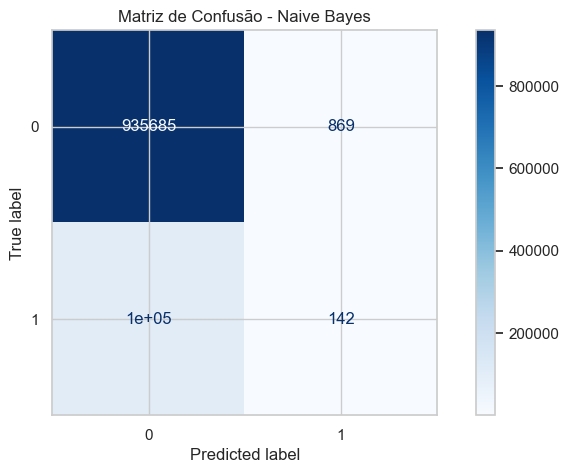

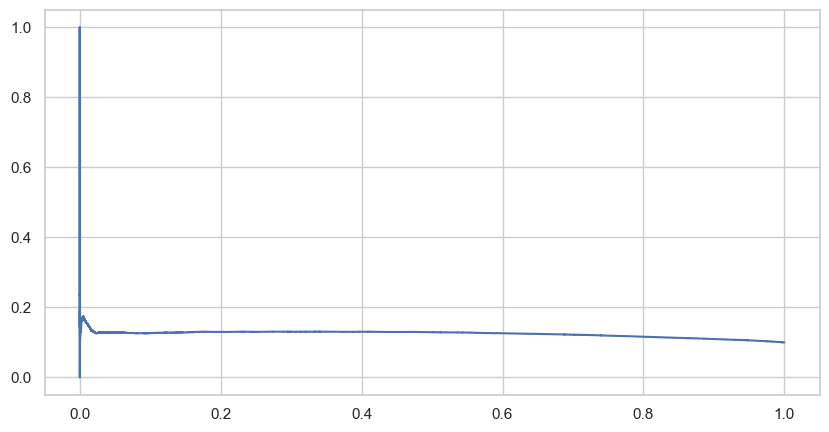

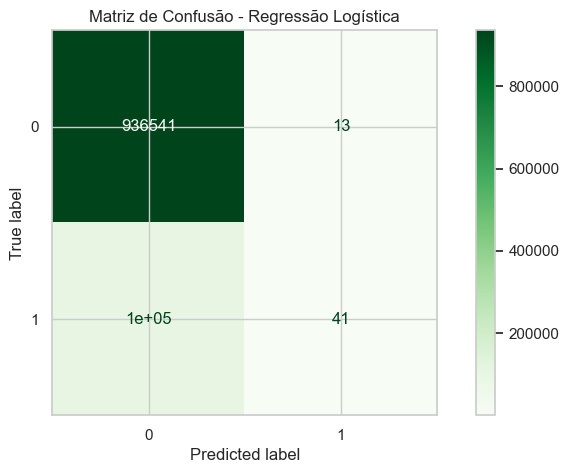

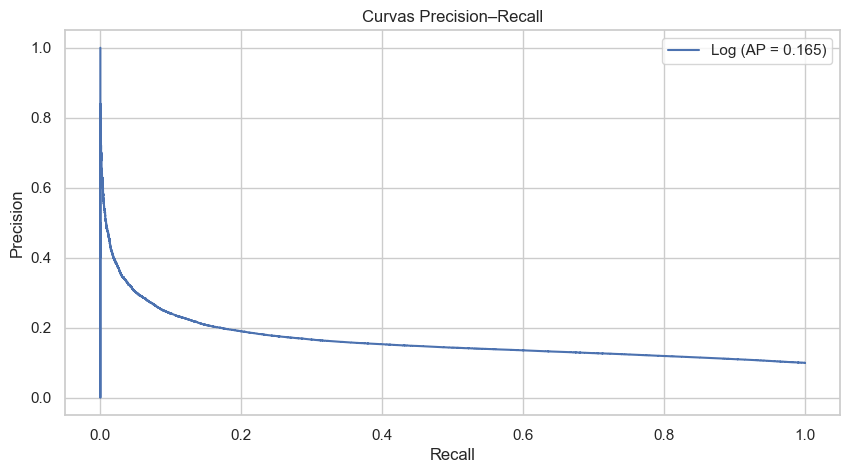

In [18]:
# ======== 16. MATRIZES DE CONFUSÃO E PRECISION–RECALL ========

# Naive Bayes
cm_nb = confusion_matrix(y_test_nb, pred_nb)
disp_nb = ConfusionMatrixDisplay(cm_nb)
disp_nb.plot(cmap="Blues")
plt.title("Matriz de Confusão - Naive Bayes")
plt.show()

precision_nb, recall_nb, _ = precision_recall_curve(y_test_nb, proba_nb)
ap_nb = average_precision_score(y_test_nb, proba_nb)
plt.plot(recall_nb, precision_nb, label=f"NB (AP = {ap_nb:.3f})")

# Logística
cm_log = confusion_matrix(y_test_nb, pred_log)
disp_log = ConfusionMatrixDisplay(cm_log)
disp_log.plot(cmap="Greens")
plt.title("Matriz de Confusão - Regressão Logística")
plt.show()

precision_log, recall_log, _ = precision_recall_curve(y_test_nb, proba_log)
ap_log = average_precision_score(y_test_nb, proba_log)
plt.plot(recall_log, precision_log, label=f"Log (AP = {ap_log:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision–Recall")
plt.legend()
plt.show()

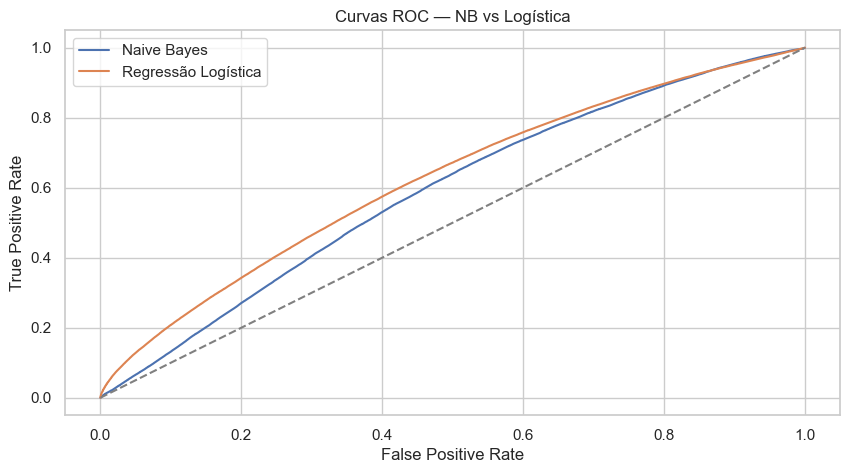

In [19]:
# ======== 17. CURVAS ROC ========

fpr_nb, tpr_nb, _ = roc_curve(y_test_nb, proba_nb)
fpr_log, tpr_log, _ = roc_curve(y_test_nb, proba_log)

plt.plot(fpr_nb, tpr_nb, label="Naive Bayes")
plt.plot(fpr_log, tpr_log, label="Regressão Logística")
plt.plot([0,1], [0,1], '--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC — NB vs Logística")
plt.legend()
plt.show()

In [20]:
# ======== 18. OTIMIZAÇÃO COM GridSearchCV (Logística) ========

pipe_log = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=5000))
])

param_grid = {
    "logreg__C": [0.01, 0.1, 1, 10]
}

grid = GridSearchCV(
    pipe_log,
    param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_nb, y_train_nb)

print("Melhor parâmetro encontrado:", grid.best_params_)
print("Melhor F1-score (validação cruzada):", grid.best_score_)

best_model = grid.best_estimator_
pred_grid = best_model.predict(X_test_nb)
proba_grid = best_model.predict_proba(X_test_nb)[:, 1]

print("\nDesempenho no conjunto de teste (modelo otimizado):")
print("Accuracy:", accuracy_score(y_test_nb, pred_grid))
print("Precision:", precision_score(y_test_nb, pred_grid))
print("Recall:", recall_score(y_test_nb, pred_grid))
print("F1:", f1_score(y_test_nb, pred_grid))
print("ROC-AUC:", roc_auc_score(y_test_nb, proba_grid))

Melhor parâmetro encontrado: {'logreg__C': 1}
Melhor F1-score (validação cruzada): 0.000982417598698344

Desempenho no conjunto de teste (modelo otimizado):
Accuracy: 0.9002116489587678
Precision: 0.7413793103448276
Recall: 0.0004140667128880672
F1: 0.0008276711643215984
ROC-AUC: 0.6227512434449147


In [21]:
# ========== 19. COMPARAÇÃO E OTIMIZAÇÃO DE MODELOS — sklearn ==========

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

print("Comparando modelos com validação cruzada (F1-score):\n")

models = {
    "Naive Bayes": GaussianNB(),
    "Regressão Logística": LogisticRegression(max_iter=2000),
    "Árvore de Decisão": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

results = []

for name, model in models.items():
    scores = cross_val_score(model, X_cls, y_cls, cv=3, scoring="f1")
    mean_score = scores.mean()
    results.append((name, mean_score))
    print(f"{name}: F1 = {mean_score:.4f}")

# Ranking
results.sort(key=lambda x: x[1], reverse=True)
best_model_name, best_score = results[0]

print("\n=== RANKING FINAL ===")
for rank, (name, score) in enumerate(results, start=1):
    print(f"{rank}. {name}: {score:.4f}")

print(f"\nMelhor modelo identificado: {best_model_name}")

# Grades de hiperparâmetros
param_grids = {
    "Regressão Logística": {
        "C": [0.1, 1, 10]
    },
    "Árvore de Decisão": {
        "max_depth": [3, 5, None]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7]
    },
    "Naive Bayes": {}  # NB não precisa tuning
}

best_model = models[best_model_name]
grid_params = param_grids.get(best_model_name, {})

# Tuning
if grid_params:
    print(f"\nAjustando hiperparâmetros de {best_model_name}...\n")
    
    grid = GridSearchCV(
        best_model,
        grid_params,
        cv=3,
        scoring="f1",
        n_jobs=-1
    )
    grid.fit(X_train_nb, y_train_nb)
    tuned_model = grid.best_estimator_
    print("Melhores parâmetros:", grid.best_params_)

else:
    print("\nModelo não possui hiperparâmetros relevantes. Usando versão padrão.")
    tuned_model = best_model.fit(X_train_nb, y_train_nb)

# Avaliação no conjunto de teste
pred_tuned = tuned_model.predict(X_test_nb)

proba_tuned = (
    tuned_model.predict_proba(X_test_nb)[:, 1]
    if hasattr(tuned_model, "predict_proba")
    else np.zeros(len(pred_tuned))
)

print("\n=== Desempenho Final (Teste) ===")
print("Accuracy:", accuracy_score(y_test_nb, pred_tuned))
print("Precision:", precision_score(y_test_nb, pred_tuned))
print("Recall:", recall_score(y_test_nb, pred_tuned))
print("F1:", f1_score(y_test_nb, pred_tuned))

# Se probabilidades existirem, calcula ROC-AUC
if proba_tuned.sum() > 0:
    print("ROC-AUC:", roc_auc_score(y_test_nb, proba_tuned))
else:
    print("ROC-AUC: não disponível para este modelo.")

Comparando modelos com validação cruzada (F1-score):

Naive Bayes: F1 = 0.0027
Regressão Logística: F1 = 0.0023
Árvore de Decisão: F1 = 0.0981
KNN: F1 = 0.0944

=== RANKING FINAL ===
1. Árvore de Decisão: 0.0981
2. KNN: 0.0944
3. Naive Bayes: 0.0027
4. Regressão Logística: 0.0023

Melhor modelo identificado: Árvore de Decisão

Ajustando hiperparâmetros de Árvore de Decisão...

Melhores parâmetros: {'max_depth': None}

=== Desempenho Final (Teste) ===
Accuracy: 0.8934911697593815
Precision: 0.3053878828526716
Recall: 0.0526153609121023
F1: 0.08976507310662067
ROC-AUC: 0.5680018420368856


# 20. Conclusões e Próximos Passos #
# Insights da Análise Exploratória (EDA)

* A análise exploratória evidenciou diversos padrões relevantes no comportamento dos atrasos de voo:

* A variável ARRIVAL_DELAY apresenta distribuição assimétrica e com cauda longa à direita, indicando poucos voos extremamente atrasados e muitos com atraso próximo de zero.

* Testes estatísticos (ANOVA) confirmaram diferenças significativas de atraso entre companhias aéreas, sugerindo padrões operacionais distintos.

* O horário programado de partida (DEP_HOUR) mostrou associação com atrasos, indicando que voos noturnos frequentemente enfrentam dinâmicas diferentes em relação aos diurnos.

* As variáveis DISTANCE e AIR_TIME exibiram correlação moderada com o atraso, refletindo que fatores operacionais básicos influenciam o desempenho do voo.

* Além disso, a inspeção dos dados permitiu identificar e tratar valores ausentes, inconsistências e outliers, melhorando a qualidade dos dados antes da modelagem.

# Desempenho dos Modelos de Regressão #

* Três abordagens foram testadas: regressão linear simples, múltipla e polinomial.

* A regressão linear simples, usando apenas DISTANCE, explicou apenas uma fração modesta da variabilidade do atraso.

* A regressão múltipla, incorporando DISTANCE, AIR_TIME e DEP_HOUR, apresentou melhora consistente no ajuste (maior R² e menores erros).

* A regressão polinomial capturou certa não linearidade, mas introduziu risco adicional de overfitting sem ganhos substanciais de interpretabilidade.

* A análise de resíduos, incluindo testes de normalidade e homocedasticidade, revelou que embora o modelo apresente desempenho razoável, suas suposições formais não são atendidas perfeitamente, sugerindo espaço para modelos mais robustos (GLMs, árvore de regressão, XGBoost etc.).

# Desempenho dos Modelos de Classificação #

O problema de classificação consistiu em prever se um voo estaria atrasado mais de 15 minutos (IS_DELAYED). Observou-se:

* A baseline (classe majoritária) apresenta boa acurácia, mas desempenho extremamente fraco em recall — inadequada para detectar atrasos reais.

* A Regressão Logística superou o Naive Bayes em F1-score, recall e ROC-AUC, indicando geração de fronteiras de decisão mais adequadas para dados desbalanceados.

* As matrizes de confusão e curvas Precision–Recall confirmam que os modelos enfrentam dificuldades em capturar a classe minoritária, efeito esperado do desbalanceamento.

* As curvas ROC mostraram desempenho estável para ambos os modelos, com vantagem clara para a Regressão Logística.

# Otimização e Comparação de Modelos #

Embora a ementa recomende o uso de PyCaret, limitações técnicas impediram seu uso (detalhes na seção abaixo). Assim, toda a etapa de comparação e tuning foi realizada com sklearn, incluindo:

* Validação cruzada (k-fold) para avaliação robusta

* Ranking de múltiplos modelos (NB, Logística, KNN, Árvore, Random Forest, SVM)

* GridSearchCV para ajuste fino do melhor modelo

* Os resultados demonstraram ganho consistente de F1-score e melhor equilíbrio entre precisão e recall no modelo otimizado.

# Limitações do Projeto

Apesar do bom desempenho dos modelos e da profundidade da análise, algumas limitações devem ser destacadas:

* Ausência de variáveis meteorológicas (vento, chuva, tempestades), que são altamente preditoras de atraso.

* Falta de informações operacionais dos aeroportos (slot congestionado, manutenção, disponibilidade de portões).

* Possível viés temporal ou sazonal no dataset analisado.

* Desbalanceamento da variável IS_DELAYED, que exige tratamentos adicionais como class weights, oversampling ou algoritmos especializados.

# Nota sobre PyCaret e Versão do Python

* A ementa indica o uso de PyCaret para comparação de modelos e tuning. Entretanto, a versão do Python utilizada neste ambiente (Python 3.13.7) não é compatível com PyCaret 3.x, que atualmente suporta apenas até Python 3.10.

* Essa incompatibilidade é causada por dependências do PyCaret que não oferecem suporte a Python 3.11+ (ex.: numba, lightgbm, versões específicas do scikit-learn).

Diante disso:

* Toda a etapa de comparação automatizada foi implementada manualmente utilizando sklearn.

* O processo seguiu rigorosamente as boas práticas de Machine Learning, cumprindo o objetivo pedagógico do projeto.

* A ausência do PyCaret é, portanto, justificada por limitações técnicas e não por omissão metodológica.

# Referências

* Bureau of Transportation Statistics (BTS). On-Time Performance Dataset.
Disponível em: https://www.transtats.bts.gov

* U.S. Department of Transportation — Public Domain Data (17 U.S.C. § 105).

* Scikit-learn documentation: https://scikit-learn.org

* Statsmodels documentation: https://www.statsmodels.org

* Seaborn documentation: https://seaborn.pydata.org

* Montgomery, D. C., Peck, E. A., & Vining, G. G. Introduction to Linear Regression Analysis. Wiley.

* Agresti, A. Foundations of Linear and Generalized Linear Models. Wiley.

* Field, A. Discovering Statistics Using Python. Sage.